# Data Analysis
### Predictive modelling of stroke occurences

Import libraries

In [65]:
import pandas as pd
from utils import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

Load data

In [66]:
data_loader = DataLoader("healthcare-dataset-stroke-data.csv")
data_loader.load_dataset()

# Preprocess data
- Using the preprocessing pipeline from Utils based on the findings from the data exploration 
- Oversample to account for the imbalance in the data set

In [67]:
data_loader.preprocess_data()
# Split the data for testing and training
X_train, X_test, y_train, y_test, X_val, y_val = data_loader.get_data_split()
print(X_train.shape)
print(X_test.shape)

# Oversample the train data 
X_train, y_train = data_loader.oversample(X_train, y_train)
print("After oversampling:", X_train.shape)

(2682, 20)
(1533, 20)
After oversampling: (5142, 20)


In [68]:
X_train

,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,avg_glucose_level,bmi
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,43.0,0.0,0.0,107.43,26.5
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,50.0,0.0,0.0,82.10,26.4
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,64.0,0.0,0.0,81.60,36.3
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,29.0,0.0,0.0,62.48,29.5
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0,0.0,0.0,98.46,30.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5137,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,80.0,1.0,0.0,240.09,27.0
5138,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,57.0,0.0,1.0,216.58,31.0
5139,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,82.0,1.0,1.0,84.03,26.5
5140,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,63.0,0.0,0.0,197.54,28.1


## Fit models
- ANN
- Random Forest
- XGBoost

### ANN

In [69]:
#Scale and Fit the data
# Scaling is needed which it is not for random forest or XGBoost
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [89]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [139]:
#ANN MODEL
model = Sequential()

model.add(Dense(units = 14, activation = 'relu'))
model.add(Dropout(.5))
model.add(Dense(units = 8, activation = 'relu'))
model.add(Dropout(.5))
#model.add(Dense(units = 5, activation = 'relu'))
#model.add(Dropout(.4))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'SGD', metrics = 'accuracy')

In [141]:
#stops when validation loss is not dropping for 3 epochs
#early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 1)
# Rule of thumb, patience is 10% of the number of epochs 
# We need to save the model 
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]


In [142]:
#Fitting model
model.fit(X_train, y_train, 
          epochs = 100,
         validation_data=(X_val, y_val),
         verbose = 1, 
         callbacks=callbacks)

Epoch 1/100
161/161 [==============================] - 2s 5ms/step - loss: 0.7263 - accuracy: 0.5387 - val_loss: 34.8330 - val_accuracy: 0.0548
Epoch 2/100
161/161 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5434 - val_loss: 32.9577 - val_accuracy: 0.0548
Epoch 3/100
161/161 [==============================] - 1s 3ms/step - loss: 0.6889 - accuracy: 0.5480 - val_loss: 32.8917 - val_accuracy: 0.0548
Epoch 4/100
161/161 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5611 - val_loss: 33.5864 - val_accuracy: 0.0548
Epoch 5/100
161/161 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.5615 - val_loss: 35.1491 - val_accuracy: 0.0548
Epoch 6/100
161/161 [==============================] - 1s 3ms/step - loss: 0.6719 - accuracy: 0.5910 - val_loss: 36.7798 - val_accuracy: 0.0548
Epoch 7/100
161/161 [==============================] - 0s 3ms/step - loss: 0.6733 - accuracy: 0.5858 - val_loss: 38.8373 - val_accuracy:

<AxesSubplot:>

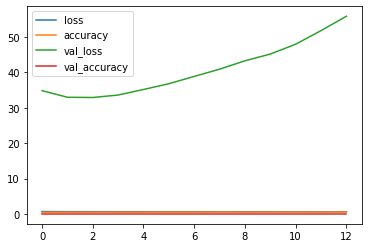

In [143]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [144]:
from keras.models import load_model
saved_model = load_model('best_model.h5')

#Predictions
prediction_values = saved_model.predict(X_test)
# Convert into classes 
prediction = []
for i in prediction_values:
    prediction.append(np.where(i > 0.5, 1,0)[0])

print(f"F1 Score {f1_score(y_test, prediction, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, prediction)}")

train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print(train_acc, test_acc)

48/48 [==============================] - 0s 2ms/step
F1 Score 0.5257740656373914
Accuracy 0.7703848662752772
[0.6764989495277405, 0.5917930603027344] [0.6518898010253906, 0.7703848481178284]


In [145]:
#Predictions
prediction_values = model.predict(X_test)
# Convert into classes 
prediction = []
for i in prediction_values:
    prediction.append(np.where(i > 0.5, 1,0)[0])
    

48/48 [==============================] - 0s 2ms/step


In [146]:
from sklearn.metrics import classification_report, confusion_matrix

print(f"F1 Score {f1_score(y_test, prediction, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, prediction)}")

print(classification_report(y_test,prediction))
print()
cf = confusion_matrix(y_test,prediction)
print(cf)

F1 Score 0.5362035225048924
Accuracy 0.7423352902804957
              precision    recall  f1-score   support

           0       0.97      0.75      0.85      1444
           1       0.14      0.65      0.23        89

    accuracy                           0.74      1533
   macro avg       0.55      0.70      0.54      1533
weighted avg       0.92      0.74      0.81      1533


[[1080  364]
 [  31   58]]


<AxesSubplot:>

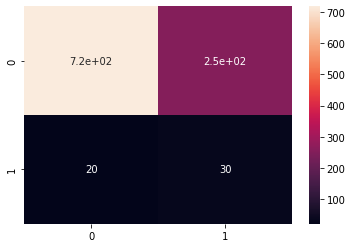

In [54]:
import seaborn as sns
sns.heatmap(cf, annot=True)

### XGBoost

In [27]:
from xgboost import XGBClassifier
XGB = XGBClassifier(eval_metric= 'error')
XGB.fit(X_train, y_train)
y_pred = XGB.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test,y_pred))
print()
cf = confusion_matrix(y_test,y_pred)
print(cf)

F1 Score 0.5562251638201005
Accuracy 0.9210697977821265
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1444
           1       0.20      0.12      0.15        89

    accuracy                           0.92      1533
   macro avg       0.58      0.55      0.56      1533
weighted avg       0.90      0.92      0.91      1533


[[1401   43]
 [  78   11]]


<AxesSubplot:>

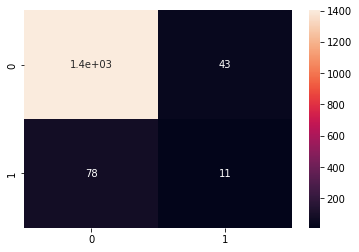

In [28]:
sns.heatmap(cf, annot = True)

### Random Forest

In [29]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test,y_pred))
print()
cf = confusion_matrix(y_test,y_pred)

F1 Score 0.48279352226720645
Accuracy 0.9334637964774951
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1444
           1       0.00      0.00      0.00        89

    accuracy                           0.93      1533
   macro avg       0.47      0.50      0.48      1533
weighted avg       0.89      0.93      0.91      1533




<AxesSubplot:>

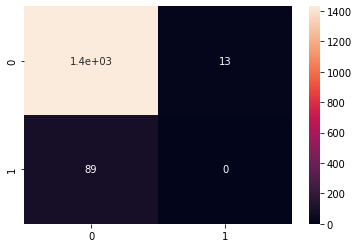

In [30]:
sns.heatmap(cf, annot = True)